In [1]:
# Tratamiento de datos
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd
import pickle

# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado y evaluación
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV

# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_pickle("data/procesados_registrado.pkl")
df.head(1)

,fecha,estacion,año,mes,festivo,dia_semana,clima,temperatura,sensacion_termica,humedad,viento,registrado,registrado_box,laboral_no,laboral_sí
0,2018-01-01,0.0,0,0.0,0,0.0,1,-0.82907,-0.67864,1.268831,-0.212121,654,267.555885,1.0,0.0


In [3]:
df.drop(["fecha", "registrado_box"], axis = 1, inplace = True)

In [4]:
# Separamos en X e y.
X = df.drop("registrado", axis = 1)
y = df["registrado"]

In [5]:
# Separamos en train y test.
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [9]:
def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):
    """
Esta función nos saca las métricas de nuestro modelo a predecir.
Args: 
    y_test(serie): los datos que tenemos.
    y_train(serie): los datos que ha predicho.
    y_test_pred(serie): los datos que tenemos.
    y_train_pred(serie): los datos que ha predicho.
    tipo_modelo(string): nombre que le damos a nuestro modelo.
Returns: devuelve un dataframe con las métricas.
    """   
    resultados = {"MAE": [mean_absolute_error(y_test, y_test_pred), mean_absolute_error(y_train, y_train_pred)],
                "MSE": [mean_squared_error(y_test, y_test_pred), mean_squared_error(y_train, y_train_pred)],
                "RMSE": [np.sqrt(mean_squared_error(y_test, y_test_pred)), np.sqrt(mean_squared_error(y_train, y_train_pred))],
                "R2":  [r2_score(y_test, y_test_pred), r2_score(y_train, y_train_pred)],
                "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    df["modelo"] = tipo_modelo
    return df

In [7]:
gs_rf = GridSearchCV(
            estimator = RandomForestRegressor(), 
            param_grid = parametros3, 
            cv = 10,  
            verbose = 0, 
            return_train_score = True, 
            scoring = "neg_mean_squared_error")

In [8]:
gs_rf.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [4, 5, 6, 7],
                         'max_features': [4, 5, 6, 7],
                         'min_samples_leaf': [2.5, 5, 10, 25],
                         'min_samples_split': [5, 10, 25, 50]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [9]:
bosque = gs_rf.best_estimator_
bosque

RandomForestRegressor(max_depth=7, max_features=5, min_samples_leaf=5,
                      min_samples_split=10)

In [10]:
with open ('modelo_registrados.pkl','wb') as f:
    pickle.dump(bosque,f)

In [42]:
parametros3

{'max_depth': [4, 5, 6, 7],
 'max_features': [4, 5, 6, 7],
 'min_samples_split': [5, 10, 25, 50],
 'min_samples_leaf': [2.5, 5, 10, 25]}

In [34]:
y_pred_test_rf = bosque.predict(x_test)
y_pred_train_rf = bosque.predict(x_train)

In [35]:
df_resultados3 = metricas(y_test, y_train, y_pred_test_rf, y_pred_train_rf, "Random Forest I")
df_resultados3

,MAE,MSE,RMSE,R2,set,modelo
0,546.067997,472437.595554,687.340960,0.781134,test,Random Forest I
1,479.476517,381976.193094,618.042226,0.846786,train,Random Forest I


In [43]:
# vamos a crearnos un dataframe 
importancia_predictores = pd.DataFrame(
                            {'predictor': x_train.columns,
                             'importancia': arbol.feature_importances_}
                            )


# ordenamos de mayor a menor los resultados
importancia_predictores.sort_values(by=["importancia"], ascending=False, inplace = True)

# printeamos los resultados
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores


Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
6,temperatura,0.404515
1,año,0.337222
7,humedad,0.088924
8,viento,0.058278
5,clima,0.035506
4,dia_semana,0.032550
2,mes,0.017846
0,estacion,0.010830
10,laboral_sí,0.006428
3,festivo,0.005173


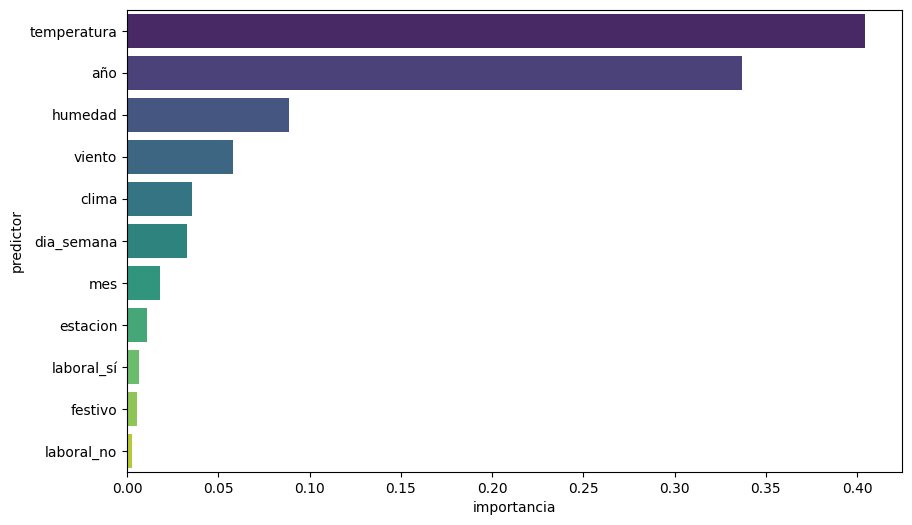

In [44]:
plt.figure(figsize=(10,6))
sns.barplot(x = "importancia", y = "predictor", data = importancia_predictores, palette="viridis");
plt.show()